In [1]:
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import FeatureUnion

import transformer

### SVM

In [2]:
schizo_csv = pd.read_csv("../response_data/schizo_responses.csv",
                      lineterminator='\n')
control_csv = pd.read_csv("../response_data/control_responses.csv",
                         lineterminator='\n')

In [3]:
headers_list = ["target", "ids", "date", "flag", "user", "text"]
training_csv = pd.read_csv("data/training.csv",
                          lineterminator='\n',
                          encoding="ISO-8859-1",
                          names=headers_list)
training_csv = training_csv.sample(n=3500).reset_index()
neutral_csv = pd.read_csv("data/processedNeutral.csv")
training_csv = training_csv.append(neutral_csv).reset_index()

In [4]:
vocab_ngram = transformer.vocab_ngram
vocab = vocab_ngram.fit(training_csv["text"]).vocabulary_

In [5]:
union = FeatureUnion([
    ("word_ngram", transformer.word_ngram),
    ("char_ngram", transformer.char_ngram),
    ("sentiment140", transformer.Sentiment140(vocab)),
    ("bingliu", transformer.BingLiu(vocab)),
    ("nrcemotion", transformer.NrcEmotion(vocab)),
    ("sentiwordnet", transformer.SentiWordNet(vocab)),
    ("senticnet", transformer.SenticNets(vocab)),
])

vector = union.fit_transform(training_csv["text"])
print(vector.shape)

X_train, X_test, y_train, y_test = train_test_split(vector, training_csv["target"], test_size=0.20)
y_train = y_train.reset_index()
y_test = y_test.reset_index()

/home/penta/.local/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(5070, 128510)


In [6]:
classifier = LinearSVC()
model = classifier.fit(X_train, y_train["target"])

/home/penta/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [7]:
y_pred = model.predict(X_test)
cr = classification_report(y_test["target"], y_pred, output_dict=True)
print("\t\tprecision     recall     f-score")
print("Negative" + '\t' + str(int(cr['0']["precision"] * 100)) + '%' + "\t      "
      + str(int(cr['0']["recall"] * 100)) + '%' + "\t "
     + str(int(cr['0']["f1-score"] * 100)) + '%')
print("Neutral" + '\t\t' + str(int(cr['2']["precision"] * 100)) + '%' + "\t      "
      + str(int(cr['2']["recall"] * 100)) + '%' + "\t "
     + str(int(cr['2']["f1-score"] * 100)) + '%')
print("Positive" + '\t' + str(int(cr['4']["precision"] * 100)) + '%' + "\t      "
      + str(int(cr['4']["recall"] * 100)) + '%' + "\t "
     + str(int(cr['4']["f1-score"] * 100)) + '%')
print()
print("Overall Accuracy: " + "\t" + str(int(cr["accuracy"] * 100)) + '%')

		precision     recall     f-score
Negative	71%	      67%	 69%
Neutral		89%	      95%	 92%
Positive	70%	      70%	 70%

Overall Accuracy: 	77%


In [8]:
schizo_vector = union.transform(schizo_csv["tweet"])
control_vector = union.transform(control_csv["tweet"])
schizo_results = model.predict(schizo_vector)
control_results = model.predict(control_vector)

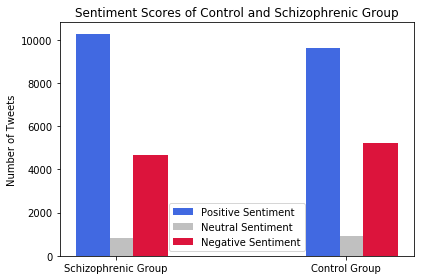

Positive Responses Schizophrenic Group: 10288
Neutral Responses Schizophrenic Group: 841
Negative Responses Schizophrenic Group: 4650

Positive Responses Control Group: 9631
Neutral Responses Control Group: 917
Negative Responses Control Group: 5231


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

positive_schizo_count = np.count_nonzero(schizo_results == 4)
neutral_schizo_count = np.count_nonzero(schizo_results == 2)
negative_schizo_count = (len(schizo_results) - (positive_schizo_count + neutral_schizo_count))

positive_control_count = np.count_nonzero(control_results == 4)
neutral_control_count = np.count_nonzero(control_results == 2)
negative_control_count = (len(control_results) - (positive_control_count + neutral_control_count))

labels = ["Schizophrenic Group", "Control Group"]
positive = [positive_schizo_count, positive_control_count]
neutral = [neutral_schizo_count, neutral_control_count]
negative = [negative_schizo_count, negative_control_count]

x = np.arange(len(labels))
width = 0.15
fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*(width/3), positive, width, label="Positive Sentiment", color="royalblue")
rects2 = ax.bar(x + (width/3), neutral, width, label="Neutral Sentiment", color="silver")
rects3 = ax.bar(x + 3*(width/3), negative, width, label="Negative Sentiment", color="crimson")

ax.set_ylabel("Number of Tweets")
ax.set_title("Sentiment Scores of Control and Schizophrenic Group")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

print("Positive Responses Schizophrenic Group: " + str(positive_schizo_count))
print("Neutral Responses Schizophrenic Group: " + str(neutral_schizo_count))
print("Negative Responses Schizophrenic Group: " + str(negative_schizo_count))
print()
print("Positive Responses Control Group: " + str(positive_control_count))
print("Neutral Responses Control Group: " + str(neutral_control_count))
print("Negative Responses Control Group: " + str(negative_control_count))

### Term Frequency

In [10]:
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

def term_freq(csv):
    word_dict = {}
    for tweet in csv["tweet"]:
        words = tweet.split(' ')
        words = [w for w in words if w.lower() not in stopwords and w != '']
        words = [w for w in words if not w.startswith('@')]
        words = [w for w in words if not w.startswith('#')]
        for word in words:
            word_dict[word] = word_dict.get(word, 0) + 1
    return Counter(word_dict).most_common(50)

freq = {}
schizo_freq = term_freq(schizo_csv)
control_freq = term_freq(control_csv)

for word, count in schizo_freq:
    freq[word] = (count, None)
for word, count in control_freq:
    if word in freq.keys():
        freq[word] = (freq[word][0], count)
    else:
        freq[word] = (None, count)
        
df = pd.DataFrame(columns=["word", "schizo", "control"])
for word in freq.keys():
    df = df.append({"word": word, "schizo": freq[word][0], "control": freq[word][1]}, ignore_index=True)


In [11]:
from IPython.display import display
display(df)

,word,schizo,control
0,like,820,574
1,get,567,467
2,I'm,526,300
3,people,467,211
4,know,466,358
5,would,448,229
6,one,446,344
7,Thank,423,204
8,think,421,256
9,good,405,267
